# RO Measurements

In [61]:
import pandas as pd
from pynq import Overlay
import numpy as np
from time import sleep
import json
from datetime import datetime, timedelta
from tqdm.notebook import tqdm

In [67]:
class TestChip(Overlay):
    """TestChip class is the main driver
    class for interacting with our FPGA Overlay
    """

    def __init__(self, ol_path, **kwargs):
        super().__init__(ol_path)
        self.RO_base_address = 0x00000000
        self.temp_sensor_address = 0x200
        self.vccint_sensor_address = 0x204
        self.vccaux_sensor_address = 0x208
        self.Vp_Vn_sensor_address = 0x20C
        self.vrefP_sensor_address = 0x210
        self.vrefN_sensor_address = 0x214
        self.vbram_sensor_address = 0x218
        self.pssvccint_sensor_address = 0x234
        self.pssvccaux_sensor_address = 0x238
        self.pssvccmem_sensor_address = 0x23C
        self.counter_address_increament = 0x04
        self.num_oscillators = 20
        ###
        self.ROs_0.write(0x00,0) # Turn off the ROS to not degrade them
        ###

    def XADC_temp(self):
        return ((self.xadc_wiz_0.read(self.temp_sensor_address
                                       ) >> 4) * 503.975/4096 - 273.15)

    def XADC_voltage(self, voltage_name='vccint'):
        if voltage_name == 'vccaux':
            measurement_out = self.xadc_wiz_0.read(self.vccaux_sensor_address)
        elif voltage_name == 'vbram':
            measurement_out = self.xadc_wiz_0.read(self.vbram_sensor_address)
        elif voltage_name == 'pssvccint':
            measurement_out = self.xadc_wiz_0.read(self.pssvccint_sensor_address)
        elif voltage_name == 'pssvccaux':
            measurement_out = self.xadc_wiz_0.read(self.pssvccaux_sensor_address)
        elif voltage_name == 'pssvccmem':
            measurement_out = self.xadc_wiz_0.read(self.pssvccmem_sensor_address)
        else:
            measurement_out = self.xadc_wiz_0.read(self.vccint_sensor_address)
        return (measurement_out >> 4) * 3/4096

    def record(self, total_samples, every, experiment = 'experiment_1'):
        """
        parameters
        ----------
        total_samples : total number of samples
        every : sampling step size in seconds
        """
        ###
        self.ROs_0.write(0x00,1) # This signal turns on the ROs
        sleep(0.01)
        ###
        data_dict = {
            **{f'RO_{i}': [] for i in range(20)},
            **{'Temperature':[], 'vccint':[], 'vbram':[], 'vccaux':[], 'time':[]}
        }
        init_time = datetime.now()
        now_time = init_time
        for s in tqdm(range(total_samples), "Sampling..."):
            ###
            self.ROs_0.write(0x00,2) # This signal pauses the counters so that all of them are measures at the same time
            data_dict['Temperature'].append(self.XADC_temp()) # temperature while counting
            sleep(0.01) # making sure that the counters stopped counting
            ###
            now_time = datetime.now()
            data_dict['time'].append(now_time)
            data_dict['vccint'].append(self.XADC_voltage('vccint'))
            data_dict['vbram'].append(self.XADC_voltage('vbram'))
            data_dict['vccaux'].append(self.XADC_voltage('vccaux'))
            for i in range(self.num_oscillators):
                data_dict[f'RO_{i}'].append(
                    self.ROs_0.read(
                        self.RO_base_address + i * self.counter_address_increament
                    )
                )
            ###
            self.ROs_0.write(0x00,1) # Turning off the pause signal
            ###
            while(datetime.now() < now_time + every):
                pass
        df = pd.DataFrame(data_dict)
        df.to_csv(experiment+'.csv')
        return df

In [87]:
ol = TestChip('ROS.bit')
every = timedelta(seconds = 3)
df = ol.record(2000, every, "experiment_2")

Sampling...:   0%|          | 0/2000 [00:00<?, ?it/s]

In [88]:
df.head()

,RO_0,RO_1,RO_2,RO_3,RO_4,RO_5,RO_6,RO_7,RO_8,RO_9,...,RO_15,RO_16,RO_17,RO_18,RO_19,Temperature,vccint,vbram,vccaux,time
0,2,474273,469586,467296,462360,459790,466916,416924,460401,460736,...,456562,452021,373717,466275,419824,50.201147,1.022461,1.022461,1.803955,2024-06-03 02:54:29.035468
1,2,474513,469981,467651,462893,460363,467208,417136,460814,461106,...,457035,452236,374144,466663,420196,49.955066,1.022461,1.022461,1.803955,2024-06-03 02:54:32.055837
2,2,474535,469958,467510,462883,460174,467155,417065,460886,461149,...,457022,452247,374099,466729,420110,50.570270,1.022461,1.022461,1.803955,2024-06-03 02:54:35.075790
3,2,474546,469874,467637,462844,460095,467242,417173,460844,461022,...,456858,452248,374086,466717,420149,50.693311,1.022461,1.022461,1.803955,2024-06-03 02:54:38.095860
4,2,474449,469955,467389,462791,460025,467013,416990,460744,460966,...,456931,452281,373937,466496,420008,50.693311,1.022461,1.022461,1.803955,2024-06-03 02:54:41.115772


<AxesSubplot:>

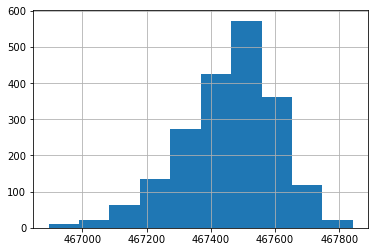

In [89]:
df["RO_3"].hist()

<AxesSubplot:>

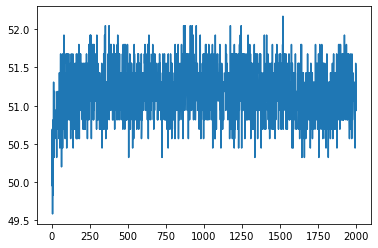

In [90]:
df["Temperature"].plot()

<AxesSubplot:>

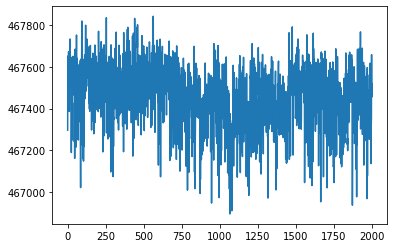

In [91]:
df["RO_3"].plot()